In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras import backend as K
from keras.layers import Dense, LSTM, TimeDistributed
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv(filepath_or_buffer="./Data/growth_rate.csv", index_col="date")

In [3]:
data = data.apply(pd.to_numeric, errors = "coerce")
#data.info()

In [4]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [5]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [40]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [41]:
data.columns

Index(['TCMNOM_Y10', 'TCMNOM_Y2', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [42]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [43]:
look_back = 10 
time_steps = 10
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed.tail()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var1(t-9),var2(t-9),...,var7(t+8),var8(t+8),var1(t+9),var2(t+9),var3(t+9),var4(t+9),var5(t+9),var6(t+9),var7(t+9),var8(t+9)
7916,-0.000397,0.000000,-0.012945,0.008123,0.012906,0.003322,-0.002633,0.003779,0.000711,0.010638,...,-0.007908,0.000128,-0.006560,0.000000,0.000000,0.002067,-0.002472,0.001985,0.007524,0.001411
7917,0.000711,0.010638,0.032787,-0.002102,-0.002905,0.008567,0.004663,-0.000779,-0.008170,0.007018,...,0.007524,0.001411,0.015667,0.010676,0.012987,-0.024239,-0.004387,-0.005306,0.002400,0.006019
7918,-0.008170,0.007018,0.012698,0.007256,0.001873,0.008423,-0.003503,-0.001559,-0.005528,0.003484,...,0.002400,0.006019,0.010851,0.010563,0.009615,-0.011099,-0.008528,0.003058,0.000887,-0.003819
7919,-0.005528,0.003484,0.012539,-0.011038,0.000291,0.004247,-0.002021,-0.006637,-0.000395,0.000000,...,0.000887,-0.003819,0.010558,-0.010453,-0.003175,-0.047969,0.013334,-0.013755,-0.000620,-0.014952
7920,-0.000395,0.000000,-0.003096,-0.010573,-0.013997,-0.003101,-0.001893,-0.001441,-0.001418,0.000000,...,-0.000620,-0.014952,-0.006317,0.024648,0.025478,-0.001965,0.000772,-0.001366,0.002660,0.000649


In [44]:
scaled = reframed.values
scaled

array([[ 0.00704504,  0.00124224, -0.00560538, ...,  0.00151855,
        -0.00034566,  0.00277823],
       [ 0.00710283, -0.01116625, -0.01014656, ...,  0.00129964,
         0.00311203,  0.00847458],
       [ 0.02463141, -0.02258469, -0.0261959 , ..., -0.00028843,
         0.00586005,  0.01325145],
       ...,
       [-0.00816952,  0.00701754,  0.01269841, ...,  0.0030581 ,
         0.00088684, -0.00381922],
       [-0.00552797,  0.00348432,  0.01253918, ..., -0.01375496,
        -0.00062024, -0.01495208],
       [-0.00039507,  0.        , -0.00309598, ..., -0.00136592,
         0.00265981,  0.00064868]], dtype=float32)

In [45]:
n_train_hours = int(len(scaled) * 0.7)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [46]:
# split into input and outputs
train_X, train_y = train[:, :-8 * time_steps], train[:, -8 * time_steps:]
test_X, test_y = test[:, :-8 * time_steps], test[:, -8 * time_steps:]

In [47]:
train_X = train_X.reshape((train_X.shape[0], look_back, number_of_variables))
test_X = test_X.reshape((test_X.shape[0], look_back, number_of_variables))
train_y = train_y.reshape((train_y.shape[0], time_steps, number_of_variables))
test_y = test_y.reshape((test_y.shape[0], time_steps, number_of_variables))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5537, 10, 8) (5537, 10, 8) (2374, 10, 8) (2374, 10, 8)


# Building the Model

In [48]:
epsilon = 1.0e-9
def qlike_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = K.log(y_pred) + y_true / y_pred
    return K.mean(loss, axis=-1)

def mse_log(y_true, y_pred):
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = K.square(K.log(y_true) - K.log(y_pred))
    return K.mean(loss, axis=-1)

def mse_sd(y_true, y_pred):
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = K.square(y_true - K.sqrt(y_pred))
    return K.mean(loss, axis=-1)    

def hmse(y_true, y_pred):
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = K.square(y_true / y_pred - 1.)
    return K.mean(loss, axis=-1)    

In [49]:
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1) #+ K.mean(loss, axis =-1)

In [50]:
def richy(y_true, y_pred):
    var_diff = K.var(y_true) - K.var(y_pred)
    abs_diff_ratio = K.mean(K.square(y_true/K.abs(y_true)- (y_pred/K.abs(y_pred))))
    return 0.5*var_diff + 0.5*abs_diff_ratio

In [51]:
def var_dir_loss(y_true, y_pred):
    var_diff = K.var(y_true)**2 - K.var(y_pred)**2
    abs_diff_ratio = K.mean(K.square(y_true/K.abs(y_true)- (y_pred/K.abs(y_pred))))
    return var_diff + abs_diff_ratio

In [52]:
model = Sequential()

model.add(LSTM(
    input_shape=(look_back,8),
    return_sequences=True, units=200))
#model.add(Dropout(0.2))

model.add(LSTM(
    150,
    return_sequences=True))


model.add(TimeDistributed(Dense(8, activation = 'linear')))
#model.add(Activation("linear"))

from keras.callbacks import ModelCheckpoint

weight_path="{}_weights.hdf5".format('lstm_growth1')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
callbacks_list = [checkpoint]

model.compile(loss="mse", optimizer="adam")
#model.compile(loss=var_dir_loss, optimizer="adam")
#model.compile(loss=richy, optimizer="adam")
#model.compile(loss=hmse, optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 200)           167200    
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 150)           210600    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 8)             1208      
Total params: 379,008
Trainable params: 379,008
Non-trainable params: 0
_________________________________________________________________


In [53]:
n_batch = 256#len(train_X)
history = model.fit(train_X, train_y, epochs=100, batch_size=n_batch, validation_data=(test_X, test_y), callbacks = callbacks_list)

Train on 5537 samples, validate on 2374 samples
Epoch 1/100
5537/5537 [==============================] - 3s 526us/step - loss: 2.0027e-04 - val_loss: 4.6199e-04

Epoch 00001: val_loss improved from inf to 0.00046, saving model to lstm_growth1_weights.hdf5
Epoch 2/100
5537/5537 [==============================] - 1s 224us/step - loss: 1.9864e-04 - val_loss: 4.6172e-04

Epoch 00002: val_loss improved from 0.00046 to 0.00046, saving model to lstm_growth1_weights.hdf5
Epoch 3/100
5537/5537 [==============================] - 1s 227us/step - loss: 1.9865e-04 - val_loss: 4.6266e-04

Epoch 00003: val_loss did not improve from 0.00046
Epoch 4/100
5537/5537 [==============================] - 1s 223us/step - loss: 1.9853e-04 - val_loss: 4.6205e-04

Epoch 00004: val_loss did not improve from 0.00046
Epoch 5/100
5537/5537 [==============================] - 1s 221us/step - loss: 1.9850e-04 - val_loss: 4.6200e-04

Epoch 00005: val_loss did not improve from 0.00046
Epoch 6/100
5537/5537 [==============


Epoch 00049: val_loss did not improve from 0.00046
Epoch 50/100
5537/5537 [==============================] - 1s 211us/step - loss: 1.9812e-04 - val_loss: 4.6235e-04

Epoch 00050: val_loss did not improve from 0.00046
Epoch 51/100
5537/5537 [==============================] - 1s 209us/step - loss: 1.9806e-04 - val_loss: 4.6269e-04

Epoch 00051: val_loss did not improve from 0.00046
Epoch 52/100
5537/5537 [==============================] - 1s 211us/step - loss: 1.9804e-04 - val_loss: 4.6261e-04

Epoch 00052: val_loss did not improve from 0.00046
Epoch 53/100
5537/5537 [==============================] - 1s 212us/step - loss: 1.9799e-04 - val_loss: 4.6394e-04

Epoch 00053: val_loss did not improve from 0.00046
Epoch 54/100
5537/5537 [==============================] - 1s 213us/step - loss: 1.9812e-04 - val_loss: 4.6282e-04

Epoch 00054: val_loss did not improve from 0.00046
Epoch 55/100
5537/5537 [==============================] - 1s 220us/step - loss: 1.9801e-04 - val_loss: 4.6313e-04

Epo

5537/5537 [==============================] - 1s 215us/step - loss: 1.9776e-04 - val_loss: 4.6346e-04

Epoch 00099: val_loss did not improve from 0.00046
Epoch 100/100
5537/5537 [==============================] - 1s 216us/step - loss: 1.9795e-04 - val_loss: 4.6386e-04

Epoch 00100: val_loss did not improve from 0.00046


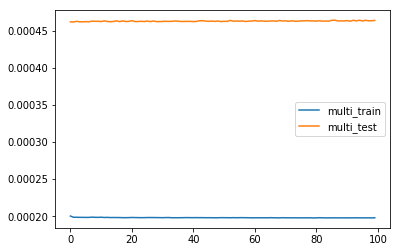

In [60]:
#multi_history = model
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [61]:
test_X.shape

(2374, 10, 8)

In [62]:
from keras.models import load_model

#multi_model = load_model("8to8market_lstm_growth_rate_model_weights.hdf5")
multi_model = model
yhat = multi_model.predict(test_X)

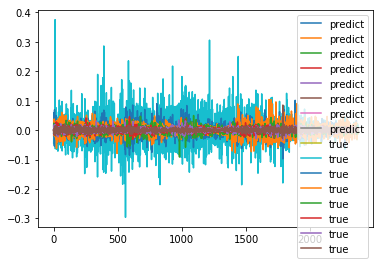

In [63]:
pyplot.plot(yhat[:,0], label='predict')
pyplot.plot(test_y[:,0], label='true')
pyplot.legend()
pyplot.show()

In [64]:
rmse = sqrt(mean_squared_error(yhat[:,0], test_y[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.022


In [65]:
predictDates = data.tail(len(test_y)).index
actual_chart = go.Scatter(x=predictDates, y=test_y[:,0][:,0], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=yhat[:,0][:,0], name= 'Multi Predict Price')
py.iplot([multi_predict_chart])

In [66]:
py.iplot([multi_predict_chart, actual_chart])